In [101]:
#CNN

In [102]:
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import models
from collections import Counter
import matplotlib.pyplot as plt

In [103]:
def read_annotations(xml_path):
    """Parses VOC-style XML annotation and returns a list of (label, bbox)."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((label, (xmin, ymin, xmax, ymax)))
    return annotations


In [104]:
def load_image_and_annotations(filename):
    """Loads image and its corresponding annotations by filename (no extension)."""
    img_path = os.path.join(IMG_DIR, filename + '.jpg')
    xml_path = os.path.join(XML_DIR, filename + '.xml')
    image = Image.open(img_path)
    annotations = read_annotations(xml_path)
    return image, annotations

def draw_annotations(image, annotations):
    """Draws bounding boxes and labels on a copy of the input image."""
    annotated = image.copy()
    draw = ImageDraw.Draw(annotated)
    for label, (xmin, ymin, xmax, ymax) in annotations:
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
        draw.text((xmin, ymin), label, fill='red')
    return annotated


In [105]:
DATA_DIR = '/Users/avilochab/Desktop/Grad_School/CSE 802/project/archive/'

# Paths to relevant subfolders
IMG_DIR = os.path.join(DATA_DIR, 'JPEGImages')
XML_DIR = os.path.join(DATA_DIR, 'Annotations', 'Horizontal Bounding Boxes')
TRAIN_LIST_PATH = os.path.join(DATA_DIR, 'ImageSets', 'Main', 'train.txt')


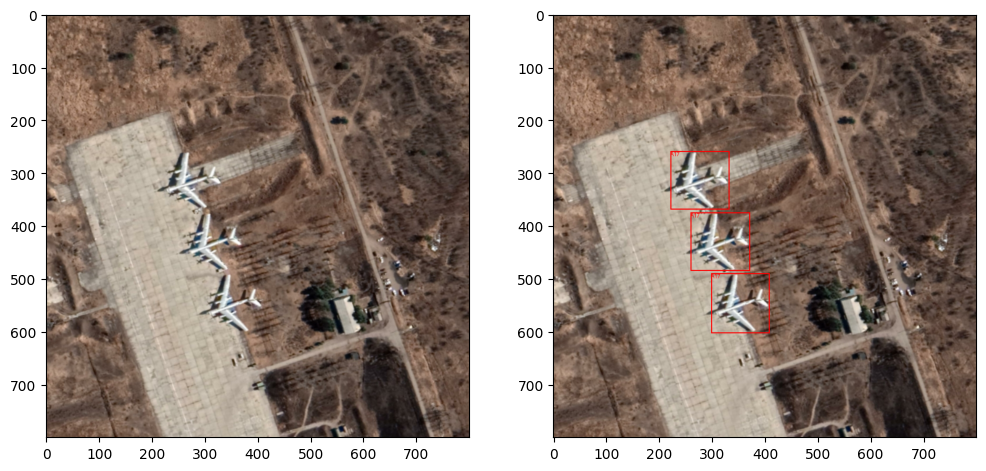

In [106]:
# Load image filenames
with open(TRAIN_LIST_PATH, 'r') as f:
    train_filenames = f.read().splitlines()

# Pick a random image
sample_file = random.choice(train_filenames)

# Load image and annotations
img, annots = load_image_and_annotations(sample_file)

# Draw annotations
img_annot = draw_annotations(img, annots)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img_annot)


In [108]:
def extract_cropped_objects(filenames, target_size=(128, 128)):
    X = []
    y = []

    for filename in filenames:
        try:
            image, annotations = load_image_and_annotations(filename)
            for label, (xmin, ymin, xmax, ymax) in annotations:
                cropped = image.crop((xmin, ymin, xmax, ymax)).convert("RGB")
                resized = cropped.resize(target_size)
                X.append(np.array(resized))
                y.append(label)


        except Exception as e:
            print(f"Skipping {filename}: {e}")
            continue

    return np.array(X), np.array(y)


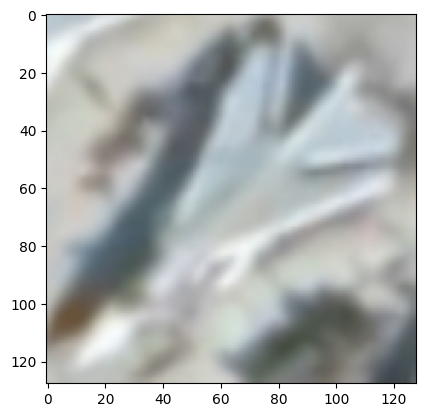

In [109]:
X_crops, y_labels = extract_cropped_objects(train_filenames[:1])
plt.imshow(X_crops[12])
plt.show()


In [110]:
subset_filenames = train_filenames[:1000]

X_raw, y_raw = extract_cropped_objects(subset_filenames)
print("✅ Extracted:")
print("X_raw shape:", X_raw.shape)
print("y_raw shape:", y_raw.shape)


✅ Extracted:
X_raw shape: (5873, 128, 128, 3)
y_raw shape: (5873,)


In [10]:
#first Model

X_raw = X_raw.astype(np.float32) / 255.0

le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [11]:
class AircraftDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = AircraftDataset(X_train, y_train, transform=transform)
test_dataset = AircraftDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(np.unique(y_encoded))


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 2.4838
Epoch 2/10, Loss: 1.4860
Epoch 3/10, Loss: 1.0683
Epoch 4/10, Loss: 0.8284
Epoch 5/10, Loss: 0.6307
Epoch 6/10, Loss: 0.5193
Epoch 7/10, Loss: 0.3953
Epoch 8/10, Loss: 0.3708
Epoch 9/10, Loss: 0.3030
Epoch 10/10, Loss: 0.3139


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n✅ Test Accuracy: {100 * correct / total:.2f}%")



✅ Test Accuracy: 89.79%


In [16]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Decode string labels if needed
print("\n✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))



✅ Classification Report:
              precision    recall  f1-score   support

          A1       0.68      0.92      0.78        71
         A10       1.00      0.96      0.98        57
         A11       0.82      0.74      0.78        19
         A12       0.85      0.72      0.78        40
         A13       0.94      0.95      0.94        78
         A14       0.93      0.89      0.91        99
         A15       0.78      0.88      0.83        33
         A16       0.97      0.97      0.97       115
         A17       0.90      0.95      0.92        63
         A18       1.00      0.81      0.89        26
         A19       1.00      0.71      0.83        79
          A2       0.98      0.95      0.96       129
         A20       0.80      0.91      0.85        69
          A3       0.96      0.81      0.88        53
          A4       0.96      1.00      0.98        25
          A5       0.91      0.95      0.93        61
          A6       0.93      0.82      0.88        17
 

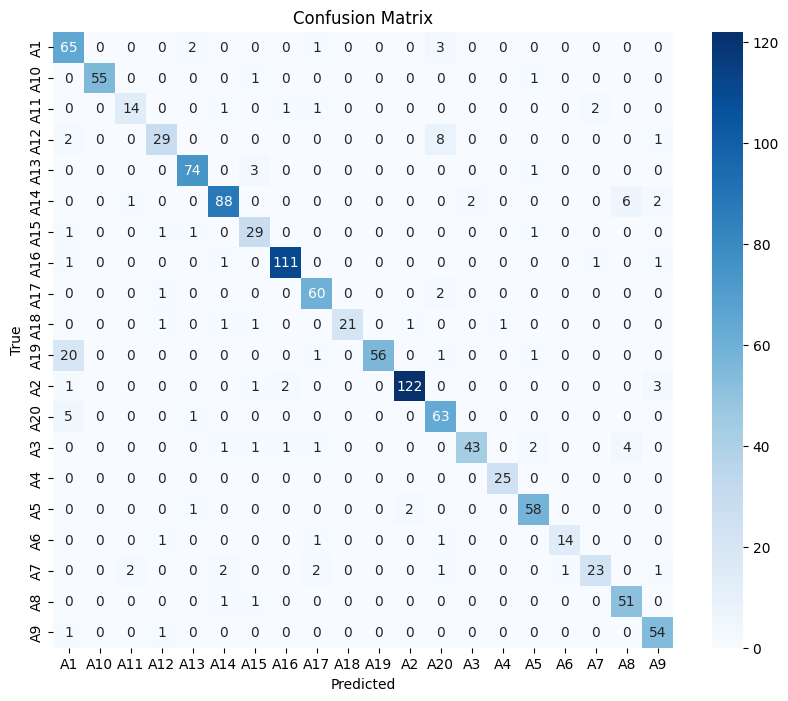

In [17]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# torch.save(model.state_dict(), "/Users/avilochab/Desktop/Grad_School/CSE 802/project/archive/aircraft_cnn_weights.pth")

In [20]:
#transfer learning with resnet

In [21]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights='IMAGENET1K_V1')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/avilochab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:21<00:00, 2.15MB/s]


In [22]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)


In [24]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [25]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 1.6835
Epoch 2/10, Loss: 0.8462
Epoch 3/10, Loss: 0.6507
Epoch 4/10, Loss: 0.5465
Epoch 5/10, Loss: 0.4725
Epoch 6/10, Loss: 0.4222
Epoch 7/10, Loss: 0.3863
Epoch 8/10, Loss: 0.3447
Epoch 9/10, Loss: 0.3236
Epoch 10/10, Loss: 0.3150


In [26]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n✅ Transfer Learning - Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))



✅ Transfer Learning - Classification Report:
              precision    recall  f1-score   support

          A1       0.70      0.75      0.72        71
         A10       0.96      0.89      0.93        57
         A11       0.61      0.58      0.59        19
         A12       0.71      0.80      0.75        40
         A13       0.87      0.91      0.89        78
         A14       0.90      0.84      0.87        99
         A15       0.78      0.76      0.77        33
         A16       0.98      0.82      0.89       115
         A17       0.91      0.97      0.94        63
         A18       0.92      0.85      0.88        26
         A19       0.73      0.77      0.75        79
          A2       0.97      0.95      0.96       129
         A20       0.77      0.83      0.80        69
          A3       0.86      0.79      0.82        53
          A4       0.77      0.92      0.84        25
          A5       0.79      0.87      0.83        61
          A6       1.00      0.71  

In [31]:
X_resized = []

for img in X_raw:
    pil_img = Image.fromarray((img * 255).astype("uint8"))
    resized_img = pil_img.resize((224, 224))
    X_resized.append(np.array(resized_img).astype(np.float32) / 255.0)

X_resized = np.array(X_resized)


✅ Resized shape: (5873, 224, 224, 3)


In [32]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X_resized, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
num_classes = len(np.unique(y_encoded))


In [33]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

class AircraftDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = AircraftDataset(X_train, y_train, transform=transform_train)
test_dataset = AircraftDataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)


In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/10 - Loss: 0.2626
Epoch 2/10 - Loss: 0.1171
Epoch 3/10 - Loss: 0.0684
Epoch 4/10 - Loss: 0.0497
Epoch 5/10 - Loss: 0.0311
Epoch 6/10 - Loss: 0.0312
Epoch 7/10 - Loss: 0.0240
Epoch 8/10 - Loss: 0.0188
Epoch 9/10 - Loss: 0.0173
Epoch 10/10 - Loss: 0.0160


In [37]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

error_rate = 1 - np.mean(np.array(all_preds) == np.array(all_labels))
print(f"🔎 Empirical Error Rate: {error_rate:.4f} ({error_rate * 100:.2f}%)")



✅ Classification Report:
              precision    recall  f1-score   support

          A1       0.89      0.99      0.93        71
         A10       1.00      1.00      1.00        57
         A11       0.94      0.79      0.86        19
         A12       0.93      1.00      0.96        40
         A13       0.97      1.00      0.99        78
         A14       0.96      1.00      0.98        99
         A15       1.00      0.88      0.94        33
         A16       1.00      0.99      1.00       115
         A17       0.98      0.98      0.98        63
         A18       1.00      0.92      0.96        26
         A19       0.97      0.90      0.93        79
          A2       1.00      1.00      1.00       129
         A20       0.97      0.99      0.98        69
          A3       1.00      0.98      0.99        53
          A4       0.96      1.00      0.98        25
          A5       1.00      0.98      0.99        61
          A6       1.00      0.88      0.94        17
 

In [38]:
torch.save(model.state_dict(), "/Users/avilochab/Desktop/Grad_School/CSE 802/project/archive/aircraft_cnn_weights_best.pth")

In [66]:
#Data augmentation

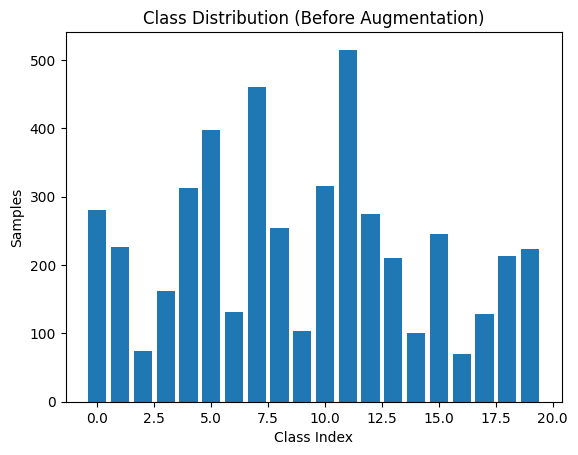

In [67]:
class_counts = Counter(y_train)
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution (Before Augmentation)")
plt.xlabel("Class Index")
plt.ylabel("Samples")
plt.show()


In [78]:
import torchvision.transforms as transforms

basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=(3, 3)),
    transforms.ToTensor()
])


In [79]:
from torchvision.transforms import functional as F
import torch

target_size = (128, 128)

augmented_X = []
augmented_y = []

for i in range(len(X_train)):
    image = X_train[i]
    label = y_train[i]

    # Ensure all images are in the same shape
    base_image = Image.fromarray((image * 255).astype(np.uint8)).resize(target_size)
    tensor_image = F.to_tensor(base_image)

    augmented_X.append(tensor_image.numpy())
    augmented_y.append(label)

    if label_counts[label] < min_count:
        for _ in range(3):  # More augmentations for low-sample classes
            aug_img = aug_transform(image)
            aug_resized = F.resize(aug_img, target_size)
            augmented_X.append(aug_resized.numpy())
            augmented_y.append(label)


In [80]:
X_train_aug = np.stack(augmented_X)
y_train_aug = np.array(augmented_y)

print("✅ Augmented train set shape:", X_train_aug.shape)


✅ Augmented train set shape: (6519, 3, 128, 128)


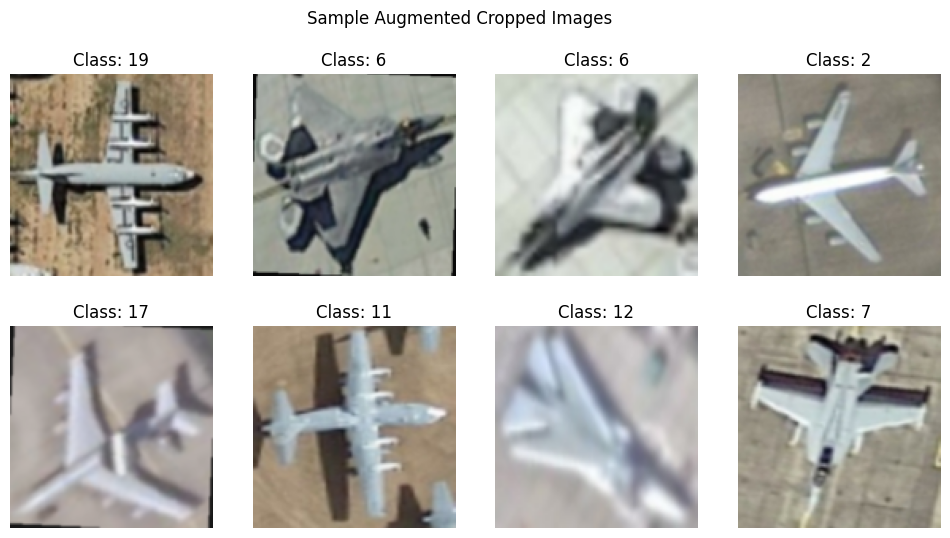

In [81]:
import random

plt.figure(figsize=(12, 6))
for i in range(8):
    idx = random.randint(0, len(X_train_aug)-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(np.transpose(X_train_aug[idx], (1, 2, 0)))
    plt.title(f"Class: {y_train_aug[idx]}")
    plt.axis('off')
plt.suptitle("Sample Augmented Cropped Images")
plt.show()


In [86]:
from PIL import Image
from torchvision.transforms import functional as F
import numpy as np

resized_X_aug = []

for img in X_train_aug:
    if isinstance(img, np.ndarray):
        # Convert from CHW → HWC
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))  # (128, 128, 3)

        if img.shape == (128, 128, 3):
            try:
                pil_img = Image.fromarray((img * 255).astype(np.uint8))
                resized = F.resize(pil_img, (224, 224))
                tensor_img = F.to_tensor(resized)
                resized_X_aug.append(tensor_img.numpy())
            except Exception as e:
                print(f"❌ Skipped image due to error: {e}")


In [87]:
X_train_resized = np.stack(resized_X_aug)
print("✅ ResNet-compatible shape:", X_train_resized.shape)  # Should be (N, 3, 224, 224)


✅ ResNet-compatible shape: (6519, 3, 224, 224)


In [88]:
train_dataset = AircraftDataset(X_train_resized, y_train_aug)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


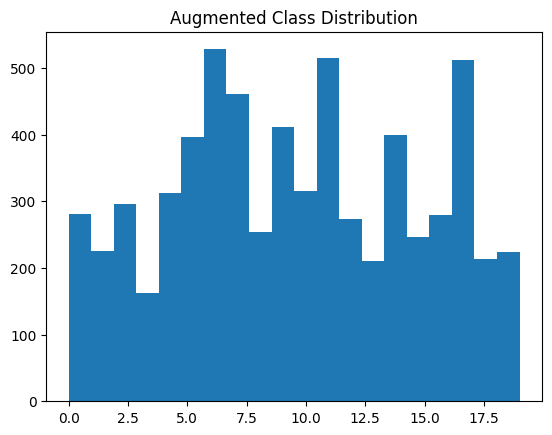

In [89]:
from collections import Counter
import matplotlib.pyplot as plt

Counter(y_train_aug)
plt.hist(y_train_aug, bins=num_classes)
plt.title("Augmented Class Distribution")
plt.show()


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/10 - Loss: 0.7840
Epoch 2/10 - Loss: 0.0973
Epoch 3/10 - Loss: 0.0320
Epoch 4/10 - Loss: 0.0138
Epoch 5/10 - Loss: 0.0083
Epoch 6/10 - Loss: 0.0072
Epoch 7/10 - Loss: 0.0109
Epoch 8/10 - Loss: 0.0033
Epoch 9/10 - Loss: 0.0027
Epoch 10/10 - Loss: 0.0023


In [91]:
from torchvision.transforms import functional as F

def resize_batch_to_224(batch):
    return torch.stack([F.resize(img, (224, 224)) for img in batch])


In [92]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = resize_batch_to_224(images).to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\n📊 Classification Report (ResNet18 + Augmentation):")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Compute empirical error rate
error_rate = 1 - np.mean(np.array(all_preds) == np.array(all_labels))
print(f"🔎 Empirical Error Rate: {error_rate:.4f} ({error_rate * 100:.2f}%)")



📊 Classification Report (ResNet18 + Augmentation):
              precision    recall  f1-score   support

          A1       0.94      0.96      0.95        71
         A10       1.00      1.00      1.00        57
         A11       1.00      0.84      0.91        19
         A12       0.98      1.00      0.99        40
         A13       0.96      1.00      0.98        78
         A14       0.97      1.00      0.99        99
         A15       1.00      0.94      0.97        33
         A16       1.00      0.99      1.00       115
         A17       0.98      1.00      0.99        63
         A18       1.00      0.92      0.96        26
         A19       0.97      0.96      0.97        79
          A2       1.00      0.99      1.00       129
         A20       0.99      0.97      0.98        69
          A3       0.96      0.96      0.96        53
          A4       0.93      1.00      0.96        25
          A5       1.00      1.00      1.00        61
          A6       1.00      

In [93]:
model_path = "cnn_with_resnet18_augmentedData.pth"
torch.save(model.state_dict(), model_path)
print(f"\n💾 Model saved successfully to '{model_path}'")



💾 Model saved successfully to 'cnn_with_resnet18_augmentedData.pth'


In [94]:
#Final summary runs

In [95]:
import copy
from sklearn.metrics import accuracy_score
import numpy as np

n_trials = 5
accuracies = []
error_rates = []

for trial in range(n_trials):
    print(f"\n🎬 Trial {trial+1}/{n_trials} -------------------------------")

    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for name, param in model.named_parameters():
        param.requires_grad = "layer4" in name or "fc" in name
    model = model.to(device)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = resize_batch_to_224(images).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    err = 1 - acc
    accuracies.append(acc)
    error_rates.append(err)

    print(f"✅ Trial {trial+1} Accuracy: {acc * 100:.2f}% | Error Rate: {err * 100:.2f}%")

    torch.save(model.state_dict(), f"resnet18_trial_{trial+1}.pth")



🎬 Trial 1/5 -------------------------------
Epoch 1 - Loss: 0.7583
Epoch 2 - Loss: 0.0968
Epoch 3 - Loss: 0.0303
Epoch 4 - Loss: 0.0137
Epoch 5 - Loss: 0.0103
Epoch 6 - Loss: 0.0060
Epoch 7 - Loss: 0.0046
Epoch 8 - Loss: 0.0048
Epoch 9 - Loss: 0.0097
Epoch 10 - Loss: 0.0034
✅ Trial 1 Accuracy: 97.28% | Error Rate: 2.72%

🎬 Trial 2/5 -------------------------------
Epoch 1 - Loss: 0.7715
Epoch 2 - Loss: 0.0970
Epoch 3 - Loss: 0.0292
Epoch 4 - Loss: 0.0133
Epoch 5 - Loss: 0.0109
Epoch 6 - Loss: 0.0063
Epoch 7 - Loss: 0.0038
Epoch 8 - Loss: 0.0040
Epoch 9 - Loss: 0.0023
Epoch 10 - Loss: 0.0024
✅ Trial 2 Accuracy: 97.70% | Error Rate: 2.30%

🎬 Trial 3/5 -------------------------------
Epoch 1 - Loss: 0.7692
Epoch 2 - Loss: 0.0910
Epoch 3 - Loss: 0.0308
Epoch 4 - Loss: 0.0150
Epoch 5 - Loss: 0.0083
Epoch 6 - Loss: 0.0054
Epoch 7 - Loss: 0.0041
Epoch 8 - Loss: 0.0030
Epoch 9 - Loss: 0.0027
Epoch 10 - Loss: 0.0022
✅ Trial 3 Accuracy: 97.45% | Error Rate: 2.55%

🎬 Trial 4/5 ------------------

In [96]:
print("\n📈 Final Accuracy Stats Across Trials:")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Standard Deviation: {np.std(accuracies) * 100:.2f}%")
print(f"Empirical Error Rate: {np.mean(error_rates) * 100:.2f}% ± {np.std(error_rates) * 100:.2f}%")



📈 Final Accuracy Stats Across Trials:
Mean Accuracy: 97.43%
Standard Deviation: 0.22%
Empirical Error Rate: 2.57% ± 0.22%


In [97]:
#Different Train-Test Splits

In [112]:
for trial in range(n_trials):
    print(f"\n=== Trial {trial + 1} / {n_trials} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_encoded, test_size=0.2, stratify=y_encoded, random_state=trial * 42
    )

    train_dataset = AircraftDataset(X_train, y_train, transform=transform)
    test_dataset = AircraftDataset(X_test, y_test, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"  Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    err = 1 - acc
    accuracies.append(acc)
    error_rates.append(err)

    print(f"✅ Trial {trial+1} Accuracy: {acc * 100:.2f}% | Error Rate: {err * 100:.2f}%")



=== Trial 1 / 5 ===
  Epoch 1/10, Loss: 2.3506
  Epoch 2/10, Loss: 1.3241
  Epoch 3/10, Loss: 0.9039
  Epoch 4/10, Loss: 0.6566
  Epoch 5/10, Loss: 0.5250
  Epoch 6/10, Loss: 0.3981
  Epoch 7/10, Loss: 0.3123
  Epoch 8/10, Loss: 0.2866
  Epoch 9/10, Loss: 0.2260
  Epoch 10/10, Loss: 0.2091
✅ Trial 1 Accuracy: 85.62% | Error Rate: 14.38%

=== Trial 2 / 5 ===
  Epoch 1/10, Loss: 2.4385
  Epoch 2/10, Loss: 1.4370
  Epoch 3/10, Loss: 1.0012
  Epoch 4/10, Loss: 0.7358
  Epoch 5/10, Loss: 0.6040
  Epoch 6/10, Loss: 0.4939
  Epoch 7/10, Loss: 0.4062
  Epoch 8/10, Loss: 0.3387
  Epoch 9/10, Loss: 0.3000
  Epoch 10/10, Loss: 0.2582
✅ Trial 2 Accuracy: 87.91% | Error Rate: 12.09%

=== Trial 3 / 5 ===
  Epoch 1/10, Loss: 2.5236
  Epoch 2/10, Loss: 1.5578
  Epoch 3/10, Loss: 1.1158
  Epoch 4/10, Loss: 0.8750
  Epoch 5/10, Loss: 0.6880
  Epoch 6/10, Loss: 0.5445
  Epoch 7/10, Loss: 0.4510
  Epoch 8/10, Loss: 0.3803
  Epoch 9/10, Loss: 0.3351
  Epoch 10/10, Loss: 0.2925
✅ Trial 3 Accuracy: 84.51% |

In [114]:
print("\n📈 Final Summary over Trials:")
for i in range(n_trials):
    print(f"Trial {i+1}: Accuracy = {accuracies[i]*100:.2f}% | Error = {error_rates[i]*100:.2f}%")




📈 Final Summary over Trials:
Trial 1: Accuracy = 85.62% | Error = 14.38%
Trial 2: Accuracy = 87.91% | Error = 12.09%
Trial 3: Accuracy = 84.51% | Error = 15.49%
Trial 4: Accuracy = 85.53% | Error = 14.47%
Trial 5: Accuracy = 80.68% | Error = 19.32%
